In [71]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [4]:
import os
import IPython
import librosa as lr
import numpy as np
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display

NFFT = int(1006)

path = 'C:/Users/erikv/Desktop/IP/samples/' 
dirs = os.listdir(path)
#IPython.display.display(IPython.display.Audio(path+dirs[3],rate=sroriginal))

def rosaspec(sound, NFFT):
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT):
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]

In [74]:
yoriginal1,sroriginal1 = lr.load(path+dirs[0],sr=4000)
originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)])
test = asignal/asignal.max()

print (test.shape)

(1, 504, 32, 2)


In [75]:
batchsize = 10 #len(dirs)
processed = np.zeros([batchsize, 504, 32, 2])
for i in range(batchsize):
    yoriginal,sroriginal = lr.load(path+dirs[i],sr=4000)
    originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal/asignal.max()
    processed[i] = audio

print (audio.shape,processed.shape)

(1, 504, 32, 2) (10, 504, 32, 2)


In [76]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(processed[0,166,29,0])
print(test[0,166,29,0])

Num GPUs Available:  1
4.753527110177951e-07
4.753527110177951e-07


In [77]:
input_shape = (processed.shape)
k = 2

inp = keras.Input(shape=(input_shape[1],input_shape[2],input_shape[3]))

x = layers.Conv2D(4, (3,3), activation='LeakyReLU', padding='same')(inp)
x = layers.MaxPooling2D((k, k), padding='same')(x)
x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((k, k), padding='same')(x)

x = layers.Conv2D(8,(3,3), activation='LeakyReLU',padding='same')(encoded)
x = layers.UpSampling2D((k, k))(x)
x = layers.Conv2D(4,(3,3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((k, k))(x)
decoded = layers.Conv2D(2, (3, 3), activation='LeakyReLU', padding='same')(x)

print(encoded.shape)
print(decoded.shape)
print(audio.shape)

(None, 126, 8, 8)
(None, 504, 32, 2)
(1, 504, 32, 2)


In [78]:
autoencoder = keras.Model(inp, decoded)
autoencoder.compile(optimizer='adam', loss='mean_absolute_percentage_error')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 504, 32, 2)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 504, 32, 4)        76        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 252, 16, 4)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 252, 16, 8)        296       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 8, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 8, 8)         584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 252, 16, 8)        0   

In [83]:
autoencoder.fit(processed,processed,
                epochs=100,
                batch_size=1,
                shuffle=False,
                validation_data = (test,test))


Epoch 1/100
10/10 [==============================] - 0s 10ms/step - loss: 33860.0273 - val_loss: 15282.9727
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 26993.6191 - val_loss: 16314.1250
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 9356.1152 - val_loss: 3537.7488
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 23082.6699 - val_loss: 15478.6982
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 13689.1748 - val_loss: 10310.5615
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 12960.7236 - val_loss: 16077.3848
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 30283.2910 - val_loss: 10361.7939
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 14644.9297 - val_loss: 9798.6807
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 15754.6406 - val_loss: 15145.5508
Epoch 10/100
10/10 [===================

10/10 [==============================] - 0s 6ms/step - loss: 13173.9980 - val_loss: 12588.8359
Epoch 78/100
10/10 [==============================] - 0s 6ms/step - loss: 18400.5703 - val_loss: 17381.3535
Epoch 79/100
10/10 [==============================] - 0s 7ms/step - loss: 38830.5742 - val_loss: 17429.1855
Epoch 80/100
10/10 [==============================] - 0s 6ms/step - loss: 24919.8555 - val_loss: 13245.9443
Epoch 81/100
10/10 [==============================] - 0s 7ms/step - loss: 14124.3359 - val_loss: 3413.8279
Epoch 82/100
10/10 [==============================] - 0s 6ms/step - loss: 12264.3291 - val_loss: 14815.5996
Epoch 83/100
10/10 [==============================] - 0s 6ms/step - loss: 24876.3633 - val_loss: 21396.2617
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 21054.7871 - val_loss: 6722.6050
Epoch 85/100
10/10 [==============================] - 0s 7ms/step - loss: 29117.6191 - val_loss: 3721.9170
Epoch 86/100
10/10 [========================

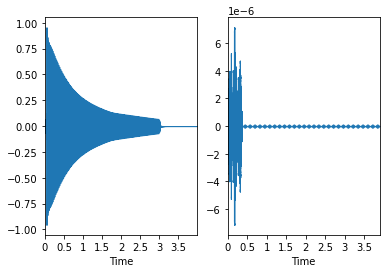

In [84]:
decoded_array = autoencoder.predict(test)[0]
decoded_audio = irosaspec(decoded_array,NFFT)

enprobe = rosaspec(yoriginal1, NFFT)
deprobe = irosaspec(enprobe,NFFT)

#noisy = yoriginal+np.random.normal(0,0.01,64000)
#ennoisy = rosaspec(noisy, NFFT)
#denoisy = irosaspec(ennoisy,NFFT)


plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal,sr=sroriginal)
plt.show()


#IPython.display.display(IPython.display.Audio(file))
IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal))
#IPython.display.display(IPython.display.Audio(noisy,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(denoisy,rate=sroriginal))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))





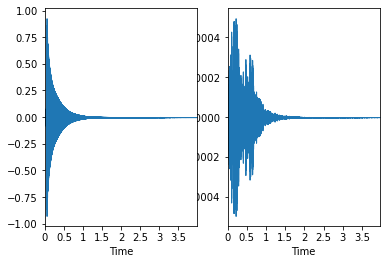

In [22]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 14.7

b, a = butter_lowpass(cutoff, fs, order)

filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(deprobe,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>